# Unsupervised Timeseries Representations
## Goal
Explore the extent of representation transferability allowed
by the algorithm described in [Unsupervised Scalable Representation Learning for Multivariate Time Series](https://arxiv.org/abs/1901.10738).

* Compare the transferability of representations learned using TimeNet and the convolutional architecture.
* Measure info change as output sequence length decreases, compare to principal components
* Introduce measure/standard testing procedure for transferability
* Rate corpus datasets by acc/(factor accntg. for dataset instances, dataset length, dataset classes)
* Do datasets with more classes work better as corpus sets?

## Method
1. Divide UCR timeseries dataset
    * Subset for learning representations
    * Subset for SVM classification
2. Train encoder network(s) on dataset to learn representations
3. Generate representations for classification dataset
4. Train and test SVM on classification dataset representations
   * Test on representation dataset
   * Test on different dataset
5. Compare with TimeNet if time

The dataset curation method is the focus of this research. We will test the transferability of
representations learned from two independent variables:
* dataset size
* dataset diversity

### Background
Info to include:
* Timeseries intro
* UCR dataset
* Concept and benefits of representations
* Encoder architecture
* Transfer ability
* What algo devs did to test transferability and how this extends that

In [10]:
# Imports
import pandas as pd
import numpy as np
import matrixprofile as mp
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras import layers, models
from keras.utils import Sequence
import keras.backend as K
import tensorflow as tf
import tensorflow_addons as tfa
import sktime
import time
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from functools import partial
import os

import sys

sys.path.insert(1, '../UnsupervisedScalableRepresentationLearningTimeSeries/')
sys.path.insert(1, '../TimeNet/')

from scikit_wrappers import CausalCNNEncoderClassifier
# from timenet import TimeNet, SimpleSeriesGenerator

In [20]:
# Load data
import uea_ucr_datasets as archive

catalog= archive.list_datasets()

def standardize(X):
    mean = np.nanmean(X)
    std = np.sqrt(np.nanvar(X))

    for sample in X:
        sample = (sample - mean) / std

    return X

def get_dataset(name):
  d_train = archive.Dataset(name)
  d_test = archive.Dataset(name, train=False)

  max_train_len = max(map(lambda t: t[0].shape[0], d_train))
  max_test_len = max(map(lambda t: t[0].shape[0], d_test))
  max_len = max(max_train_len, max_test_len)

  X_train = np.array(list(map(lambda t: pad_array(t[0], max_len), d_train)))
  y_train = np.array(list(map(lambda t: t[1], d_train)))

  X_test = np.array(list(map(lambda t: pad_array(t[0], max_len), d_test)))
  y_test = np.array(list(map(lambda t: t[1], d_test)))

  X = np.concatenate([X_train, X_test])
  y = np.concatenate([y_train, y_test])

  try:
    X = standardize(X)
  except:
    print('Failed on', name)

  X = X.swapaxes(1, 2)

  labels = np.unique(y)
  transform = {}
  for i, l in enumerate(labels):
    transform[l] = i
  y = np.vectorize(lambda l: transform[l])(y)

  return X, y

def pad_array(x, length):
  assert x.ndim == 2
  assert x.shape[1] == 1
  
  if len(x) == length:
    return x

  x_padded = np.empty((length, 1))
  x[:] = np.nan
  x_padded[:len(x)] = x

  return x_padded

def pad_matrix(X, length):
  assert X.ndim == 3
  assert X.shape[1] == 1

  if X.shape[2] == length:
    return X
  
  X_padded = np.empty((X.shape[0], 1, length))
  X_padded[:] = np.nan
  for i in range(X.shape[0]):
    X_padded[i, :, :X.shape[2]] = X[i]
  return X_padded

  # return keras.preprocessing.sequence.pad_sequences(X[:, 0, :], value=np.nan, dtype='float32', padding='post', maxlen=length)[:, np.newaxis, :]

def build_sampled_dataset(name, size=100):
  X, y = get_dataset(name)
  sample_idx = np.random.choice(X.shape[0], size=size)
  samples = X[sample_idx]
  sample_labels = y[sample_idx]

  assert len(samples) == size

  return samples, sample_labels

def build_mixed_dataset(size=1000, diversity=5):
  # sample_labels only meaningful when diversity==1

  samples_per_dataset = size // diversity
  remainder = size % diversity

  dataset_names = list(map(lambda i: catalog[i], np.random.choice(len(catalog), size=diversity)))
  datasets = {name: build_sampled_dataset(name, size=samples_per_dataset) for name in dataset_names}

  max_len = max([d[0].shape[2] for d in datasets.values()])

  for name in datasets.keys():
    datasets[name] = pad_matrix(datasets[name][0], max_len), datasets[name][1]

  samples = np.concatenate(list(map(lambda d: d[0], list(datasets.values()))))
  sample_labels = np.concatenate(list(map(lambda d: d[1], list(datasets.values()))))

  if remainder:
    X_rem, y_rem = build_sampled_dataset(dataset_names[0], size=remainder)
    X_rem = pad_matrix(X_rem, max_len)

    samples = np.concatenate([samples, X_rem])
    sample_labels = np.concatenate([sample_labels, y_rem])

  assert len(samples) == size
  assert len(sample_labels) == size

  return samples, sample_labels, dataset_names

In [31]:
# Varying size
sample_sizes = [50, 100, 500, 1000]
dataset_names = ['ElectricDevices', 'EthanolLevel', 'Phoneme', 'ECG5000', 'Earthquakes']

metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

results_df = pd.DataFrame(columns=['train_dataset', 'test_dataset', 'samples', 'train_time'] + metric_names)

for dataset_name in dataset_names:
  for size in sample_sizes:
    X, y = build_sampled_dataset(dataset_name, size)

    # Train encoder
    cnn_encoder = CausalCNNEncoderClassifier(nb_random_samples=5,
                                             depth=10,
                                             channels=40,
                                             out_channels=160,
                                             reduced_size=320,
                                             nb_steps=1500,
                                             batch_size=16,
                                             kernel_size=3,
                                             early_stopping=3,
                                             cuda=True)
    
    start = time.time()
    cnn_encoder.fit(X, y)
    end = time.time()

    train_time = end - start

    cnn_encoder.save_encoder(os.path.join(drive_base, f'TDM/models/{dataset_name}-{size}'))

    # Test
    cls = cnn_encoder.classifier
    
    for d_name in dataset_names:
      results = {m_name: [] for m_name in metric_names}
      results['train_dataset'] = dataset_name
      results['test_dataset'] = d_name
      results['samples'] = size
      results['train_time'] = train_time

      X_full, y_full = get_dataset(d_name)
      representations = cnn_encoder.encode(X_full)

      cv = StratifiedKFold(n_splits=3)
      for train_split, test_split in cv.split(representations, y_full):
        X_train, y_train = representations[train_split], y_full[train_split]
        X_test, y_test = representations[test_split], y_full[test_split]

        cls.fit(X_train, y_train)
        pred = cls.predict(X_test)

        for m_name, f in metric_dict.items():
          results[m_name].append(f(y_test, pred))
      
      for m_name in metric_names:
        results[m_name] = np.mean(results[m_name])

      print('Results:')
      print(results)

      results_df = results_df.append(results, ignore_index=True)
      results_df.to_csv(os.path.join(drive_base, 'TDM/cnn_encoder_varied_size.csv'))

KeyboardInterrupt: ignored

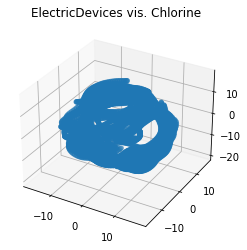

In [66]:
# t-SNE
# tsne_encoder = CausalCNNEncoderClassifier(nb_random_samples=5,
#                                              depth=10,
#                                              channels=40,
#                                              out_channels=160,
#                                              reduced_size=320,
#                                              nb_steps=1500,
#                                              batch_size=16,
#                                              kernel_size=3,
#                                              early_stopping=3,
#                                              cuda=True)
tsne_encoder.load_encoder('models/ElectricDevices-1000')

X, _ = get_dataset('ChlorineConcentration')
encodings = tsne_encoder.encode(X)

tsne = TSNE(n_components=3).fit_transform(X[:, 0, :])

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('ElectricDevices vis. Chlorine')
ax.scatter(*zip(*tsne))
plt.savefig('data/imgs/tsne_ElectricDevices_Chlorine.png')

In [ ]:
pd.set_option('display.max_rows', None)
df = pd.read_csv('data/cnn_encoder_varied_size.csv', index_col=0)
df[['train_dataset', 'test_dataset', 'accuracy', 'samples']].sort_values('accuracy',
                                                                         ascending=False)[:100]

In [ ]:
corrs = {}
for d in df['train_dataset'].unique():
    v = df.loc[df['train_dataset'] == d]
    corrs[d] = v.corr()['samples']['accuracy']

print(corrs)

In [ ]:
df.corr()['samples']['accuracy']

In [ ]:
for ds in df['train_dataset'].unique():
    plt.clf()
    x = get_dataset(ds)[0][0][0, :]
    ax = sns.lineplot(x=np.arange(len(x)), y=x)
    ax.set_title(ds)
    plt.savefig(f'data/imgs/{ds}_sample.png')

In [ ]:
# Varied diversity
test_set_names = ['ElectricDevices', 'EthanolLevel', 'Phoneme', 'ECG5000', 'Earthquakes']
diversities = [1, 3, 5, 10, 20, 40]
# diversities = [20, 40]
# diversities = [1, 3, 10, 20, 40]
samples = 500
reps = 3

metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

results_diversity_df = pd.DataFrame(columns=['diversity', 'samples', 'train_time', 'test_dataset'] + metric_names)
# results_diversity_df = pd.read_csv(os.path.join(drive_base, 'TDM/cnn_encoder_diversity.csv'))

for diversity in diversities:
  for rep in range(reps):
    try:
      X, _, _ = build_mixed_dataset(samples, diversity=diversity)

      # Train encoder
      cnn_encoder = CausalCNNEncoderClassifier(nb_random_samples=5,
                                              depth=10,
                                              channels=40,
                                              out_channels=160,
                                              reduced_size=320,
                                              nb_steps=1500,
                                              batch_size=16,
                                              kernel_size=3,
                                              cuda=True)
      
      start = time.time()
      cnn_encoder.fit_encoder(X)
      end = time.time()

      train_time = end - start

      cnn_encoder.save_encoder(os.path.join(drive_base, f'TDM/models/{diversity}-{samples}'))

      # Test
      cls = SVC()

      for d_name in test_set_names:
        results = {m_name: [] for m_name in metric_names}
        results['test_dataset'] = d_name
        results['diversity'] = diversity
        results['samples'] = samples
        results['train_time'] = train_time

        X_full, y_full = get_dataset(d_name)
        representations = np.nan_to_num(cnn_encoder.encode(X_full))

        cv = StratifiedKFold(n_splits=3)
        for train_split, test_split in cv.split(representations, y_full):
          X_train, y_train = representations[train_split], y_full[train_split]
          X_test, y_test = representations[test_split], y_full[test_split]

          cls.fit(X_train, y_train)
          pred = cls.predict(X_test)

          for m_name, f in metric_dict.items():
            results[m_name].append(f(y_test, pred))
    
        for m_name in metric_names:
          results[m_name] = np.mean(results[m_name])

        print('Results:')
        print(results)

        results_diversity_df = results_diversity_df.append(results, ignore_index=True)
        results_diversity_df.to_csv(os.path.join(drive_base, 'TDM/cnn_encoder_diversity.csv'))
    except Exception as e:
      print(e)

In [ ]:
# TimeNet varying size
sample_sizes = [50, 100, 500, 1000]
dataset_names = ['ElectricDevices', 'EthanolLevel', 'Phoneme', 'ECG5000', 'Earthquakes']

metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

results_tn_df = pd.DataFrame(columns=['train_dataset', 'test_dataset', 'samples', 'train_time'] + metric_names)

for dataset_name in dataset_names:
  for size in sample_sizes:
    X, y = build_sampled_dataset(dataset_name, size)

    # Train encoder
    timenet = TimeNet(size=60, 
                      num_layers=3,
                      dropout=0.4)
    
    gen = SimpleSeriesGenerator(X)

    start = time.time()
    timenet.train(gen, nb_epoch=20)
    end = time.time()

    train_time = end - start

    # Test
    cls = SVC()
    
    for d_name in dataset_names:
      results = {m_name: [] for m_name in metric_names}
      results['train_dataset'] = dataset_name
      results['test_dataset'] = d_name
      results['samples'] = size
      results['train_time'] = train_time

      X_full, y_full = get_dataset(d_name)
      t_gen = SimpleSeriesGenerator(X_full)
      representations = timenet.encode(t_gen)

      cv = StratifiedKFold(n_splits=3)
      for train_split, test_split in cv.split(representations, y_full):
        X_train, y_train = representations[train_split], y_full[train_split]
        X_test, y_test = representations[test_split], y_full[test_split]

        cls.fit(X_train, y_train)
        pred = cls.predict(X_test)

        for m_name, f in metric_dict.items():
          results[m_name].append(f(y_test, pred))
      
      for m_name in metric_names:
        results[m_name] = np.mean(results[m_name])

      print('Results:')
      print(results)

      results_tn_df = results_df.append(results, ignore_index=True)
      results_tn_df.to_csv(os.path.join(drive_base, 'TDM/timenet_varied_size.csv'))

In [ ]:
# Varied diversity
test_set_names = ['ElectricDevices', 'EthanolLevel', 'Phoneme', 'ECG5000', 'Earthquakes']
diversities = [1, 3, 5, 10, 20, 40]
samples = 500
reps = 3

metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

results_tn_diversity_df = pd.DataFrame(columns=['diversity', 'smples', 'train_time', 'test_dataset'] + metric_names)

for diversity in diversities:
  for rep in range(reps):
    try:
      X, _, _ = build_mixed_dataset(samples, diversity=diversity)

      # Train encoder
      timenet = TimeNet(size=60, 
                      num_layers=3,
                      dropout=0.4)
    
      gen = SimpleSeriesGenerator(X)
      
      start = time.time()
      timenet.train(gen)
      end = time.time()

      train_time = end - start

      # Test
      cls = SVC()

      for d_name in test_set_names:
        results = {m_name: [] for m_name in metric_names}
        results['test_dataset'] = d_name
        results['diversity'] = diversity
        results['samples'] = samples
        results['train_time'] = train_time

        X_full, y_full = get_dataset(d_name)
        representations = np.nan_to_num(timenet.encode(X_full))

        cv = StratifiedKFold(n_splits=3)
        for train_split, test_split in cv.split(representations, y_full):
          X_train, y_train = representations[train_split], y_full[train_split]
          X_test, y_test = representations[test_split], y_full[test_split]

          cls.fit(X_train, y_train)
          pred = cls.predict(X_test)

          for m_name, f in metric_dict.items():
            results[m_name].append(f(y_test, pred))
    
        for m_name in metric_names:
          results[m_name] = np.mean(results[m_name])

        print('Results:')
        print(results)

        results_tn_diversity_df = results_tn_diversity_df.append(results, ignore_index=True)
        results_tn_diversity_df.to_csv(os.path.join(drive_base, 'TDM/timenet_diversity.csv'))
    except Exception as e:
      print(e)

In [47]:
# Compare

,train_dataset,test_dataset,accuracy,samples
48,Phoneme,ECG5000,0.938401,100
58,Phoneme,ECG5000,0.938200,1000
73,ECG5000,ECG5000,0.937001,500
43,Phoneme,ECG5000,0.937000,50
53,Phoneme,ECG5000,0.936400,500
78,ECG5000,ECG5000,0.929201,1000
63,ECG5000,ECG5000,0.928200,50
13,ElectricDevices,ECG5000,0.927201,500
18,ElectricDevices,ECG5000,0.926600,1000
68,ECG5000,ECG5000,0.924001,100


In [50]:
corrs = {}
for d in df['train_dataset'].unique():
    v = df.loc[df['train_dataset'] == d]
    corrs[d] = v.corr()['samples']['accuracy']

print(corrs)

{'ElectricDevices': 0.019084937094876527, 'EthanolLevel': -0.005443499968885056, 'Phoneme': 0.0006735136948993183, 'ECG5000': 0.004212358540197074, 'Earthquakes': 0.011224891076314952}


In [49]:
df.corr()['samples']['accuracy']

0.00601062525968641

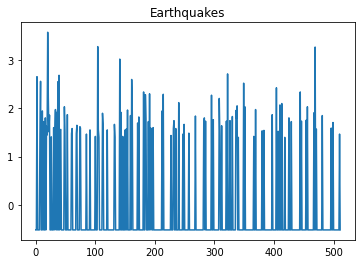

In [42]:
for ds in df['train_dataset'].unique():
    plt.clf()
    x = get_dataset(ds)[0][0][0, :]
    ax = sns.lineplot(x=np.arange(len(x)), y=x)
    ax.set_title(ds)
    plt.savefig(f'data/imgs/{ds}_sample.png')

In [ ]:
# Varied diversity
test_set_names = ['ElectricDevices', 'EthanolLevel', 'Phoneme', 'ECG5000', 'Earthquakes']
diversities = [1, 3, 5, 10, 20, 40]
# diversities = [20, 40]
# diversities = [1, 3, 10, 20, 40]
samples = 500
reps = 3

metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

results_diversity_df = pd.DataFrame(columns=['diversity', 'samples', 'train_time', 'test_dataset'] + metric_names)
# results_diversity_df = pd.read_csv(os.path.join(drive_base, 'TDM/cnn_encoder_diversity.csv'))

for diversity in diversities:
  for rep in range(reps):
    try:
      X, _, _ = build_mixed_dataset(samples, diversity=diversity)

      # Train encoder
      cnn_encoder = CausalCNNEncoderClassifier(nb_random_samples=5,
                                              depth=10,
                                              channels=40,
                                              out_channels=160,
                                              reduced_size=320,
                                              nb_steps=1500,
                                              batch_size=16,
                                              kernel_size=3,
                                              cuda=True)
      
      start = time.time()
      cnn_encoder.fit_encoder(X)
      end = time.time()

      train_time = end - start

      cnn_encoder.save_encoder(os.path.join(drive_base, f'TDM/models/{diversity}-{samples}'))

      # Test
      cls = SVC()

      for d_name in test_set_names:
        results = {m_name: [] for m_name in metric_names}
        results['test_dataset'] = d_name
        results['diversity'] = diversity
        results['samples'] = samples
        results['train_time'] = train_time

        X_full, y_full = get_dataset(d_name)
        representations = np.nan_to_num(cnn_encoder.encode(X_full))

        cv = StratifiedKFold(n_splits=3)
        for train_split, test_split in cv.split(representations, y_full):
          X_train, y_train = representations[train_split], y_full[train_split]
          X_test, y_test = representations[test_split], y_full[test_split]

          cls.fit(X_train, y_train)
          pred = cls.predict(X_test)

          for m_name, f in metric_dict.items():
            results[m_name].append(f(y_test, pred))
    
        for m_name in metric_names:
          results[m_name] = np.mean(results[m_name])

        print('Results:')
        print(results)

        results_diversity_df = results_diversity_df.append(results, ignore_index=True)
        results_diversity_df.to_csv(os.path.join(drive_base, 'TDM/cnn_encoder_diversity.csv'))
    except Exception as e:
      print(e)

In [ ]:
# TimeNet varying size
sample_sizes = [50, 100, 500, 1000]
dataset_names = ['ElectricDevices', 'EthanolLevel', 'Phoneme', 'ECG5000', 'Earthquakes']

metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

results_tn_df = pd.DataFrame(columns=['train_dataset', 'test_dataset', 'samples', 'train_time'] + metric_names)

for dataset_name in dataset_names:
  for size in sample_sizes:
    X, y = build_sampled_dataset(dataset_name, size)

    # Train encoder
    timenet = TimeNet(size=60, 
                      num_layers=3,
                      dropout=0.4)
    
    gen = SimpleSeriesGenerator(X)

    start = time.time()
    timenet.train(gen, nb_epoch=20)
    end = time.time()

    train_time = end - start

    # Test
    cls = SVC()
    
    for d_name in dataset_names:
      results = {m_name: [] for m_name in metric_names}
      results['train_dataset'] = dataset_name
      results['test_dataset'] = d_name
      results['samples'] = size
      results['train_time'] = train_time

      X_full, y_full = get_dataset(d_name)
      t_gen = SimpleSeriesGenerator(X_full)
      representations = timenet.encode(t_gen)

      cv = StratifiedKFold(n_splits=3)
      for train_split, test_split in cv.split(representations, y_full):
        X_train, y_train = representations[train_split], y_full[train_split]
        X_test, y_test = representations[test_split], y_full[test_split]

        cls.fit(X_train, y_train)
        pred = cls.predict(X_test)

        for m_name, f in metric_dict.items():
          results[m_name].append(f(y_test, pred))
      
      for m_name in metric_names:
        results[m_name] = np.mean(results[m_name])

      print('Results:')
      print(results)

      results_tn_df = results_df.append(results, ignore_index=True)
      results_tn_df.to_csv(os.path.join(drive_base, 'TDM/timenet_varied_size.csv'))

In [ ]:
# Varied diversity
test_set_names = ['ElectricDevices', 'EthanolLevel', 'Phoneme', 'ECG5000', 'Earthquakes']
diversities = [1, 3, 5, 10, 20, 40]
samples = 500
reps = 3

metric_functions = [metrics.accuracy_score]
metric_functions.append(partial(metrics.precision_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.recall_score, average='weighted', zero_division=1))
metric_functions.append(partial(metrics.f1_score, average='weighted'))

metric_names = ['accuracy', 'precision', 'recall', 'f1']

metric_dict = dict(zip(metric_names, metric_functions))

results_tn_diversity_df = pd.DataFrame(columns=['diversity', 'smples', 'train_time', 'test_dataset'] + metric_names)

for diversity in diversities:
  for rep in range(reps):
    try:
      X, _, _ = build_mixed_dataset(samples, diversity=diversity)

      # Train encoder
      timenet = TimeNet(size=60, 
                      num_layers=3,
                      dropout=0.4)
    
      gen = SimpleSeriesGenerator(X)
      
      start = time.time()
      timenet.train(gen)
      end = time.time()

      train_time = end - start

      # Test
      cls = SVC()

      for d_name in test_set_names:
        results = {m_name: [] for m_name in metric_names}
        results['test_dataset'] = d_name
        results['diversity'] = diversity
        results['samples'] = samples
        results['train_time'] = train_time

        X_full, y_full = get_dataset(d_name)
        representations = np.nan_to_num(timenet.encode(X_full))

        cv = StratifiedKFold(n_splits=3)
        for train_split, test_split in cv.split(representations, y_full):
          X_train, y_train = representations[train_split], y_full[train_split]
          X_test, y_test = representations[test_split], y_full[test_split]

          cls.fit(X_train, y_train)
          pred = cls.predict(X_test)

          for m_name, f in metric_dict.items():
            results[m_name].append(f(y_test, pred))
    
        for m_name in metric_names:
          results[m_name] = np.mean(results[m_name])

        print('Results:')
        print(results)

        results_tn_diversity_df = results_tn_diversity_df.append(results, ignore_index=True)
        results_tn_diversity_df.to_csv(os.path.join(drive_base, 'TDM/timenet_diversity.csv'))
    except Exception as e:
      print(e)

In [ ]:
# Compare

### MatrixProfile on PTSD FMRI data

In [ ]:
df_train = pd.read_excel('data/train_data_age_matched_split.xlsx')
df_test = pd.read_excel('data/test_data_age_matched_split.xlsx')

In [ ]:
X_train = df_train.loc[1:, ~df_train.columns.isin(['SpotID', 'Paths'])].to_numpy().T
y_train = df_train.loc[0, ~df_train.columns.isin(['SpotID', 'Paths'])].to_numpy()

X_test = df_test.loc[1:, ~df_test.columns.isin(['SpotID', 'Paths'])].to_numpy().T
y_test = df_test.loc[0, ~df_test.columns.isin(['SpotID', 'Paths'])].to_numpy()

In [ ]:
plt.figure(figsize=(20, 5))
profile, figures = mp.analyze(X_train[-1])